## Importing libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps

## Reading data

In [2]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [3]:
X_train, y_train = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [4]:
X_test, y_test = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [11]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False ## Not trainable weights

# base_model.trainable = True
# for layer in base_model.layers[:-3]:
#     layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])


model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [12]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 11s/step - loss: 16833.2832 - mae: 97.8794 - val_loss: 9788.0361 - val_mae: 80.0012
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 137s 11s/step - loss: 8751.2275 - mae: 71.1657 - val_loss: 7466.4697 - val_mae: 63.4252
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 134s 11s/step - loss: 7835.4263 - mae: 63.2339 - val_loss: 6574.4971 - val_mae: 59.6203
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 133s 11s/step - loss: 6800.7920 - mae: 59.6737 - val_loss: 5891.3906 - val_mae: 55.1106
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 131s 10s/step - loss: 5825.5342 - mae: 54.6341 - val_loss: 5220.3179 - val_mae: 48.7739
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 133s 11s/step - loss: 5441.9766 - mae: 51.3121 - val_loss: 4883.7983 - val_mae: 46.8613
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 132s 11s/step - loss: 5217.0952 - mae: 49.7750 - val_loss: 4643.3242 - val_mae: 45.4962
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 132s 10s/step - loss: 4122.6592 - mae: 44.7500 - val_loss: 4446.3843 - val_mae:

## Training curves visualisation

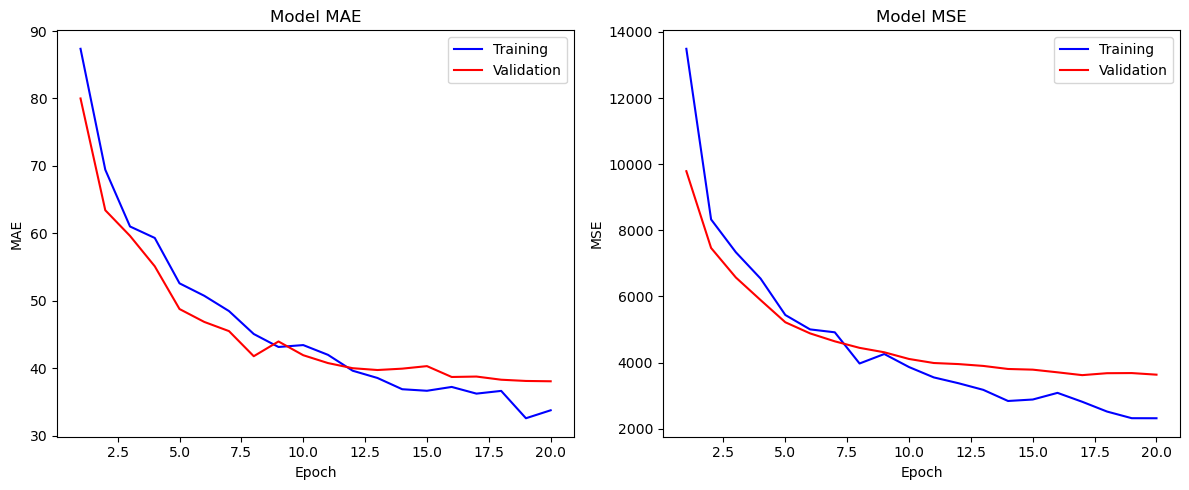

In [13]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## Making predictions

In [14]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step


In [15]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[  6.  23.]
 [220. 181.]
 [160. 157.]
 [ 21.  37.]
 [ 81.  70.]
 [ 44.  57.]
 [ 36.  44.]
 [298. 227.]
 [133. 165.]
 [337. 476.]
 [176. 139.]
 [236. 316.]
 [210. 164.]
 [ 76. 110.]
 [ 21.  20.]
 [190. 131.]
 [ 79.  48.]
 [137. 183.]
 [204. 101.]
 [269. 204.]
 [ 39.  40.]
 [115. 143.]
 [166. 146.]
 [264. 513.]
 [ 62.  70.]
 [175. 175.]
 [ 26.  51.]
 [133.  55.]
 [ 99.  67.]
 [ 24.  72.]
 [ 41.  56.]
 [136. 165.]
 [ -3.  32.]
 [217. 149.]
 [ 57.  48.]
 [144.  80.]
 [154. 117.]
 [ 51. 162.]
 [176. 137.]
 [139. 120.]
 [ 52.  72.]
 [169. 122.]
 [223. 198.]
 [110. 133.]
 [115. 147.]
 [ 32.  29.]
 [ 32.  70.]
 [ 19.  35.]
 [ 53.  24.]
 [221. 251.]
 [ 55.  59.]
 [ 74.  67.]
 [ 61.  61.]
 [229. 248.]
 [277. 252.]
 [248. 147.]
 [ 44.  57.]
 [164. 121.]
 [ 43.  47.]
 [245. 505.]
 [233. 297.]
 [261. 465.]
 [219. 167.]
 [ 47.  43.]
 [ 54.  46.]
 [ 94.  91.]
 [190. 263.]
 [182.  92.]
 [ 53. 117.]
 [ 19.  48.]
 [ 37.  54.]
 [ 74.  73.]
 [ 71. 122.]
 [ 57.  60.]
 [240. 170.]
 [ 80. 167.]
 [ 50.  57.]

## Metrics

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.5981472730636597
MSE: 3636.825927734375
MAE: 38.08544158935547
RMSE: 60.30610275268555
